## `Animal Recognition`

In [1]:
# Import the relevant libraries
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
from tensorflow.keras.metrics import Precision, Recall

2023-12-15 13:54:26.170130: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-15 13:54:27.126696: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-15 13:54:27.126818: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-15 13:54:27.132439: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-15 13:54:27.613554: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-15 13:54:27.616448: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
# Train & Test directories
train_dir = "data/train"
test_dir = "data/test"

In [3]:
# Define ImageDataGenerator and specify augmentation parameters if needed
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load and augment the data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64,64),  
    batch_size=4000,
    class_mode='categorical'  # Use 'categorical' for multi-class classification
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64,64),
    batch_size=1000,
    class_mode = 'categorical'
)

# Dataset
train_imgs, train_label = next(train_generator)
test_imgs, test_label = next(test_generator)

Found 4695 images belonging to 10 classes.
Found 1385 images belonging to 10 classes.


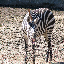

In [4]:
# Inspect image on index 20
array_to_img(train_imgs[20])

In [5]:
# Function for getting dataset shapes
class Shape():
    """Primary parameters"""
    def __init__(self, train_images, train_labels, test_images, test_labels):
        self.train_images = train_images
        self.train_labels = train_labels
        self.test_images = test_images
        self.test_labels = test_labels
   
    """Function for images"""
    def image_shape(self):
        # Return  the outputs
        return {"train_images_shape:":self.train_images.shape},{"test_images_shape:":self.test_images.shape}
       
    """Function for labels"""
    def label_shape(self):
        # Return the outputs
        return {"train_labels_shape:":self.train_labels.shape},{"test_labels_shape:":self.test_labels.shape}

    """For both outputs"""
    def output(self):
        return self.image_shape(), self.label_shape()


In [6]:
# Apply the function on the data
data_shape = Shape(train_imgs, train_label, test_imgs, test_label)
data_shape.output()

(({'train_images_shape:': (4000, 64, 64, 3)},
  {'test_images_shape:': (1000, 64, 64, 3)}),
 ({'train_labels_shape:': (4000, 10)}, {'test_labels_shape:': (1000, 10)}))

In [16]:
# Reshape the images 
train_imgs_reshaped = train_imgs.reshape(4000, -1)
test_imgs_reshaped = test_imgs.reshape(1000, -1)

# Inspect
imgs_shape = Shape(train_imgs_reshaped, train_label, test_imgs_reshaped, test_label)
imgs_shape.image_shape()

({'train_images_shape:': (4000, 12288)}, {'test_images_shape:': (1000, 12288)})

- `Inspect the labels`

In [17]:
print("Train Labels:")
train_label[:5]

Train Labels:


array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [18]:
# Specific data labels using train_indices of the generator
class_indices_train = train_generator.class_indices
class_indices_test = test_generator.class_indices

In [19]:
# Reverse one-hot-encoding
decoded_train = np.argmax(train_label, axis=1)
decoded_test = np.argmax(test_label, axis=1)
                    
# Class labels
class_labels = [
   'Bear', 'Brown bear', 'Bull', 'Butterfly', 'Camel', 'Canary', 'Caterpillar', 'Cattle', 
   'Centipede', 'Cheetah', 'Chicken', 'Crab', 'Crocodile', 'Deer', 'Duck', 'Eagle', 'Elephant',
    'Fish', 'Fox', 'Frog', 'Giraffe', 'Goat', 'Goldfish', 'Goose', 'Hamster', 'Harbor seal', 
    'Hedgehog', 'Hippopotamus', 'Horse', 'Jaguar', 'Jellyfish', 'Kangaroo', 'Koala', 'Ladybug', 
    'Leopard', 'Lion', 'Lizard', 'Lynx', 'Magpie', 'Monkey', 'Moths and butterflies', 'Mouse', 
    'Mule', 'Ostrich', 'Otter', 'Owl', 'Panda', 'Parrot', 'Penguin', 'Pig', 'Polar bear', 
    'Rabbit', 'Raccoon', 'Raven', 'Red panda', 'Rhinoceros', 'Scorpion', 'Sea lion', 
    'Sea turtle', 'Seahorse', 'Shark', 'Sheep', 'Shrimp', 'Snail', 'Snake', 'Sparrow', 'Spider', 
    'Squid', 'Squirrel', 'Starfish', 'Swan', 'Tick', 'Tiger', 'Tortoise', 'Turkey', 'Turtle', 
    'Whale', 'Woodpecker', 'Worm', 'Zebra'
    ]

# Mapping indices back to labels
decoded_labels_train= [class_labels[index] for index in decoded_train]
decoded_labels_test = [class_labels[index] for index in decoded_test]

print("train set decoded:", decoded_labels_train[:5]) # Display the first 5 decoded labels
print("test set decoded:", decoded_labels_test[:5])

train set decoded: ['Bear', 'Bear', 'Bear', 'Camel', 'Butterfly']
test set decoded: ['Bear', 'Camel', 'Butterfly', 'Bull', 'Camel']


In [20]:
# Label counts
label_counts = {label:decoded_labels_train.count(label) for label in set(decoded_labels_train)}

# Sort the labels
sorted__top_labels = sorted(label_counts, key=label_counts.get, reverse=True)[:10]
sorted_counts = {label:label_counts[label] for label in sorted__top_labels}
sorted_counts

{'Bear': 1604,
 'Camel': 722,
 'Butterfly': 621,
 'Bull': 270,
 'Canary': 254,
 'Centipede': 181,
 'Cheetah': 155,
 'Cattle': 85,
 'Caterpillar': 55,
 'Brown bear': 53}

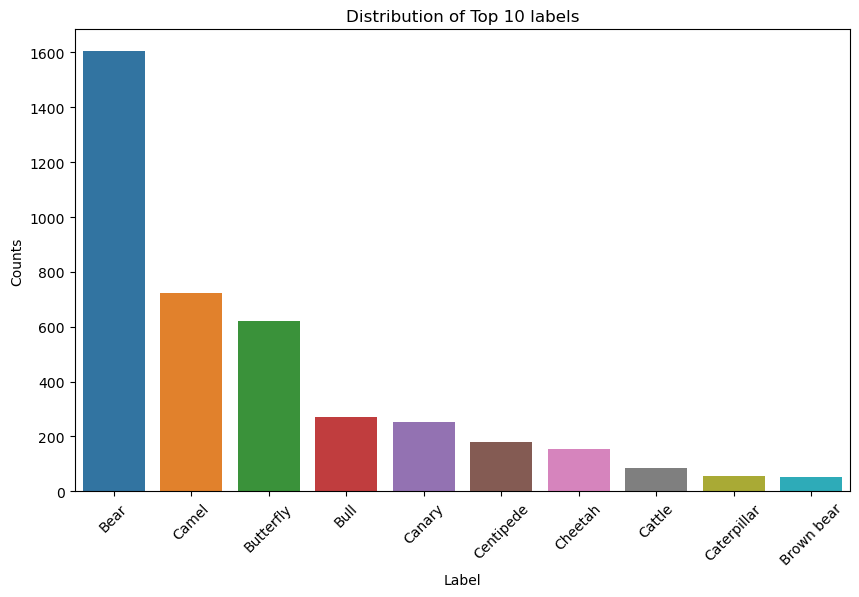

In [21]:
# Visualize the number of each image classification
fig, ax = plt.subplots(figsize=(10,6))

# Label distribution
labels = list(sorted_counts.keys())
counts = list(sorted_counts.values())
sns.barplot(x=labels, y=counts)
ax.set_xlabel("Label")
ax.set_ylabel("Counts")
ax.set_title("Distribution of Top 10 labels")
ax.tick_params(axis="x", labelrotation=45)

## `Data Preprocessing`

In [22]:
# Label encoding
encoder = LabelEncoder()
train_label_final = encoder.fit_transform(decoded_labels_train).reshape(-1,1)
test_label_final = encoder.transform(decoded_labels_test).reshape(-1,1)

In [23]:
# Apply the labe function to check on data shape
label_shape = Shape(train_imgs_reshaped, train_label_final, train_imgs_reshaped, test_label_final)
label_shape.label_shape()

({'train_labels_shape:': (4000, 1)}, {'test_labels_shape:': (1000, 1)})

- `The data is now ready for modelling.`

## `Modelling`

- `1. Baseline Dense Neural Net`

In [30]:
# Sequential model
model = Sequential() 

# Input layer with 80 layers and sigmoid activation function
model.add(layers.Dense(80, activation="sigmoid", input_shape=(12288,)))

# Hidden layer of 100 units
model.add(layers.Dense(100, activation="sigmoid"))

# Output layer
model.add(layers.Dense(1, activation="sigmoid"))

# Compile the model
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"]
              )

# Fit the model
results = model.fit(train_imgs_reshaped,
                    train_label_final,
                    batch_size=15,
                    epochs=5,
                    validation_data=(test_imgs_reshaped, test_label_final)
                    )

Epoch 1/5


2023-12-15 14:01:00.249072: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 196608000 exceeds 10% of free system memory.
/home/kinoti/anaconda3/lib/python3.11/site-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


267/267 [==============================] - 4s 14ms/step - loss: 0.0000e+00 - accuracy: 0.0132 - val_loss: 0.0000e+00 - val_accuracy: 0.0200
Epoch 2/5
267/267 [==============================] - 4s 13ms/step - loss: 0.0000e+00 - accuracy: 0.0132 - val_loss: 0.0000e+00 - val_accuracy: 0.0200
Epoch 3/5
267/267 [==============================] - 4s 14ms/step - loss: 0.0000e+00 - accuracy: 0.0132 - val_loss: 0.0000e+00 - val_accuracy: 0.0200
Epoch 4/5
267/267 [==============================] - 4s 14ms/step - loss: 0.0000e+00 - accuracy: 0.0132 - val_loss: 0.0000e+00 - val_accuracy: 0.0200
Epoch 5/5
267/267 [==============================] - 4s 14ms/step - loss: 0.0000e+00 - accuracy: 0.0132 - val_loss: 0.0000e+00 - val_accuracy: 0.0200


- `The baseline model is performing well but is slightly overfitting the training data.`

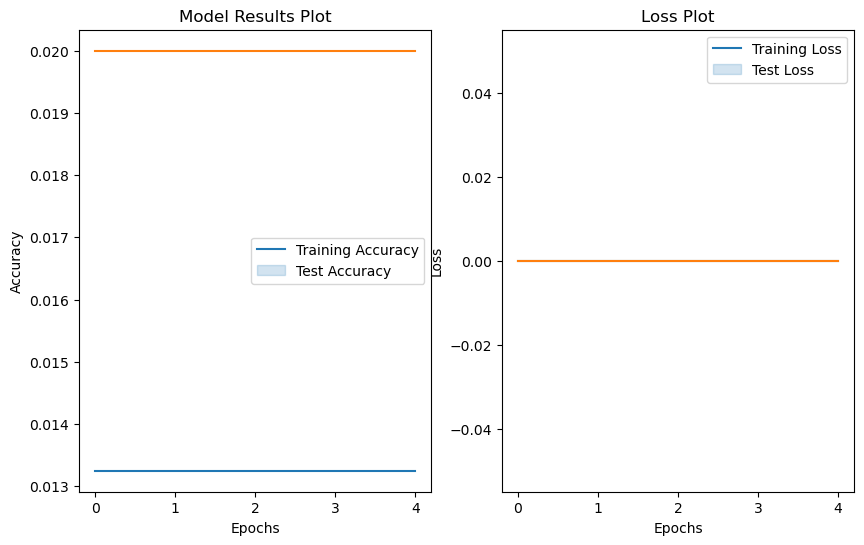

In [32]:
# Function for visualization
def model_visuals(history=results.history):
    
    # Visualozation
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
    sns.lineplot(history["accuracy"], ax=axes[0])
    sns.lineplot(history["val_accuracy"], ax=axes[0])
    sns.lineplot(history["loss"], ax=axes[1])
    sns.lineplot(history["val_loss"], ax=axes[1])
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Accuracy")
    axes[0].set_title("Model Results Plot")
    axes[0].legend(["Training Accuracy", "Test Accuracy"])

    axes[1].set_ylabel("Loss")
    axes[1].set_xlabel("Epochs")
    axes[1].set_title("Loss Plot")
    axes[1].legend(["Training Loss", "Test Loss"])

# Apply the function to the baseline model history
model_visuals(results.history)

- `2. CNN Model`

In [34]:
cnn_model = Sequential()

# Input layer of 80 units
cnn_model.add(layers.Conv2D(80, (3,3), activation="sigmoid", input_shape=(64,64,3)))
cnn_model.add(layers.MaxPooling2D((2,2)))

# Hidden layer of 100 units
cnn_model.add(layers.Conv2D(100, (4,4), activation="sigmoid"))
cnn_model.add(layers.MaxPooling2D((2,2)))

# Dense layer for interconnection
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(50, activation="sigmoid"))

# Output layer with 1 unit
cnn_model.add(layers.Dense(1, activation="sigmoid"))

# Compile the model
cnn_model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"]
                  )

cnn_model_results = cnn_model.fit(train_imgs,
                                  train_label_final,
                                  batch_size=25,
                                  epochs=5,
                                  validation_data=(test_imgs, test_label_final))

Epoch 1/5


/home/kinoti/anaconda3/lib/python3.11/site-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(25, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


160/160 [==============================] - 33s 205ms/step - loss: 0.0000e+00 - accuracy: 0.0153 - val_loss: 0.0000e+00 - val_accuracy: 0.0200
Epoch 2/5
160/160 [==============================] - 35s 222ms/step - loss: 0.0000e+00 - accuracy: 0.0132 - val_loss: 0.0000e+00 - val_accuracy: 0.0200
Epoch 3/5
160/160 [==============================] - 36s 224ms/step - loss: 0.0000e+00 - accuracy: 0.0132 - val_loss: 0.0000e+00 - val_accuracy: 0.0200
Epoch 4/5
160/160 [==============================] - 32s 199ms/step - loss: 0.0000e+00 - accuracy: 0.0132 - val_loss: 0.0000e+00 - val_accuracy: 0.0200
Epoch 5/5
160/160 [==============================] - 32s 199ms/step - loss: 0.0000e+00 - accuracy: 0.0132 - val_loss: 0.0000e+00 - val_accuracy: 0.0200


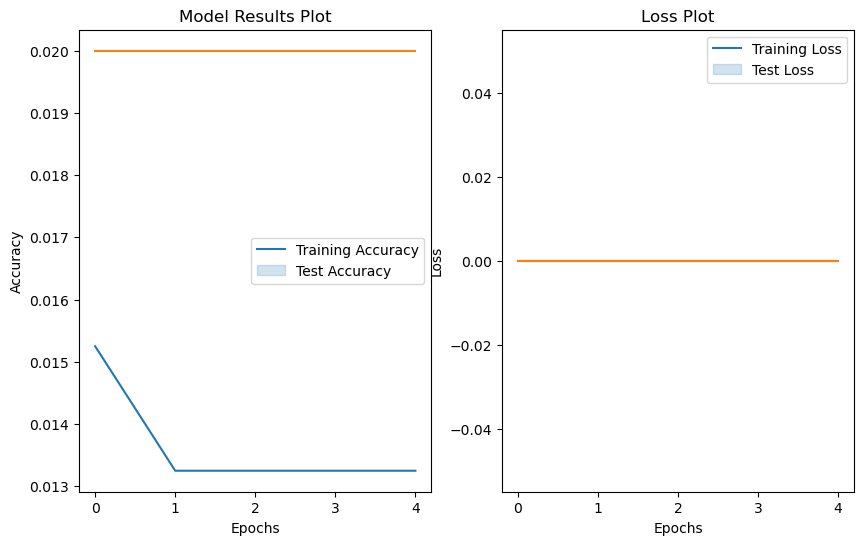

In [35]:
model_visuals(cnn_model_results.history)

- `3. Increase the size of the model`

In [39]:
final_model = Sequential()

# Input layer of 80 units
final_model.add(layers.Conv2D(80, (3,3), activation="relu", input_shape=(64,64,3)))
final_model.add(layers.MaxPooling2D((2,2)))

# First hidden layer of 100 units
final_model.add(layers.Conv2D(100, (4,4), activation="relu"))
final_model.add(layers.MaxPooling2D((2,2)))

# Second hidden layer
final_model.add(layers.Conv2D(50, (3,3), activation="relu"))
final_model.add(layers.MaxPooling2D((2,2)))

# Dense layer for interconnection
final_model.add(layers.Flatten())
final_model.add(layers.Dense(50, 
                             activation="relu"))

# Output layer with 1 unit
final_model.add(layers.Dense(1, activation="sigmoid"))

# Compile the model
final_model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy", Precision(), Recall()]
                  )

final_model_results = final_model.fit(train_imgs,
                                  train_label_final,
                                  batch_size=25,
                                  epochs=5,
                                  validation_data=(test_imgs, test_label_final))

Epoch 1/5


/home/kinoti/anaconda3/lib/python3.11/site-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(25, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


160/160 [==============================] - 31s 189ms/step - loss: 0.0000e+00 - accuracy: 0.0137 - precision_7: 0.5993 - recall_2: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.0200 - val_precision_7: 0.8750 - val_recall_2: 1.0000
Epoch 2/5
160/160 [==============================] - 32s 203ms/step - loss: 0.0000e+00 - accuracy: 0.0132 - precision_7: 0.5990 - recall_2: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.0200 - val_precision_7: 0.8750 - val_recall_2: 1.0000
Epoch 3/5
160/160 [==============================] - 32s 201ms/step - loss: 0.0000e+00 - accuracy: 0.0132 - precision_7: 0.5990 - recall_2: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.0200 - val_precision_7: 0.8750 - val_recall_2: 1.0000
Epoch 4/5
160/160 [==============================] - 30s 188ms/step - loss: 0.0000e+00 - accuracy: 0.0132 - precision_7: 0.5990 - recall_2: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.0200 - val_precision_7: 0.8750 - val_recall_2: 1.0000
Epoch 5/5
160/160 [=======================

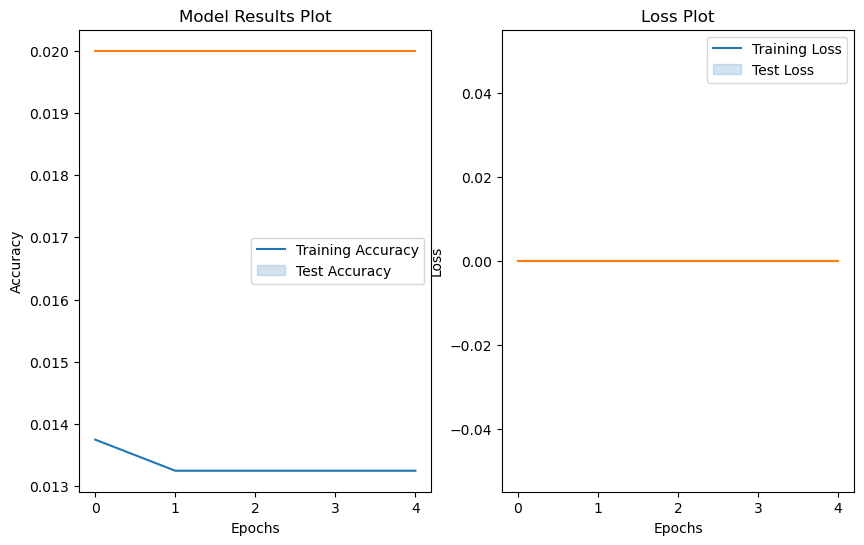

In [40]:
model_visuals(final_model_results.history)

In [41]:
# Save the model
import pickle
with open("final_model.pkl", "wb") as f:
    pickle.dump(final_model, f)

## `Deployment`